In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv',index_col = 'id')
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values('date')
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1194,2013-01-01,42,CELEBRATION,0.0,0
1193,2013-01-01,42,BREAD/BAKERY,0.0,0
1192,2013-01-01,42,BOOKS,0.0,0
1191,2013-01-01,42,BEVERAGES,0.0,0


In [3]:
test = pd.read_csv('test.csv',index_col = 'id')
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values('date')
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3002082,2017-08-16,42,CELEBRATION,0
3002081,2017-08-16,42,BREAD/BAKERY,12
3002080,2017-08-16,42,BOOKS,0
3002079,2017-08-16,42,BEVERAGES,19


In [4]:
# Check that the list of stores from the test set is the same as in the train set
(test[['store_nbr','family']].groupby(['store_nbr','family']).count().index == train[['store_nbr','family']].groupby(['store_nbr','family']).count().index).all()

True

In [5]:
# Make sure that there is one row for every date
time = datetime(2023,1,1).utcnow()
all_dates = [train['date'].min()+timedelta(days = x) for x in range((train['date'].max()-train['date'].min()).days+1)]
missing_dates = [date for date in all_dates if not(date in train['date'].values)]
to_add = pd.DataFrame([],columns = ['date','store_nbr','family','sales','onpromotion'])
ind = -1
for date in missing_dates:
    for store_nb in train['store_nbr'].unique():
        for family in train['family'].unique():
            # Make sure that there are no repeated indices.
            to_add = pd.concat([to_add,pd.DataFrame([[date,store_nb,family,0,0]],index = [ind],columns = ['date','store_nbr','family','sales','onpromotion'])])
            ind -= 1
train = pd.concat([train,to_add]).sort_values('date')
print(datetime(2023,1,1).utcnow()-time)

0:00:45.502804


## Flag outliers

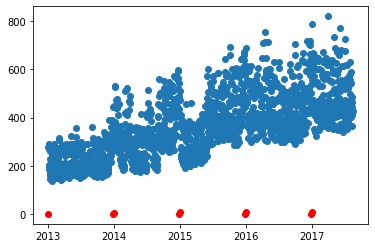

In [9]:
temp = train[['date','sales']].groupby('date').mean()
train['to_keep'] = True
train.loc[train['date'].isin(temp[temp['sales'] < 50].index),'to_keep'] = False

temp = train.loc[train['to_keep'],['date','sales']].groupby('date').mean()
plt.scatter(temp.index,temp['sales'])
temp = train.loc[~train['to_keep'],['date','sales']].groupby('date').mean()
plt.scatter(temp.index,temp['sales'],color = 'red');

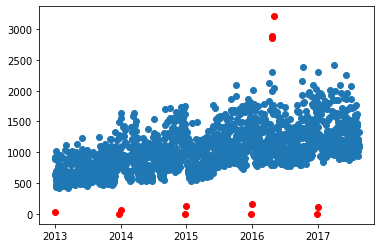

In [10]:
temp = train[['date','sales']].groupby('date').std()
train.loc[train['date'].isin(temp[temp['sales'] > 2500].index),'to_keep'] = False

temp = train.loc[train['to_keep'],['date','sales']].groupby('date').std()
plt.scatter(temp.index,temp['sales'])
temp = train.loc[~train['to_keep'],['date','sales']].groupby('date').std()
plt.scatter(temp.index,temp['sales'],color = 'red');

In [12]:
# Some stores open late in the dataset or don't even open.
temp = train.copy()
temp.loc[temp['sales'] > 0,'first_date'] = temp.loc[temp['sales'] > 0,'date']
opening_dates = temp[['store_nbr','family','first_date']].groupby(['store_nbr','family']).agg(lambda x: x.min())
opening_dates['last_date'] = temp[['store_nbr','family','first_date']].groupby(['store_nbr','family']).agg(lambda x: x.max()).rename(columns={'first_date':'last_date'})
opening_dates['sales_count'] = temp[['store_nbr','family','sales']].groupby(['store_nbr','family']).agg(lambda x: (x > 0).sum()).rename(columns={'first_date':'sales_count'})
opening_dates['sales_density'] = opening_dates['sales_count']/((opening_dates['last_date'] - opening_dates['first_date']).apply(lambda x: x.days+1))
opening_dates['closed_store'] = False
opening_dates.loc[(opening_dates['first_date'].isnull()) | (opening_dates['last_date'] < temp['date'].max() - 7*opening_dates['sales_density'].apply(lambda x: np.nan if x!=x else timedelta(days = 1/x))),'closed_store'] = True
opening_dates.head()

first_date  last_date  sales_count  sales_density  \
store_nbr family                                                         
1         AUTOMOTIVE 2013-01-02 2017-08-15         1463       0.867220   
          BABY CARE         NaT        NaT            0            NaN   
          BEAUTY     2013-01-02 2017-08-15         1430       0.847659   
          BEVERAGES  2013-01-02 2017-08-15         1678       0.994665   
          BOOKS      2016-10-13 2017-07-31          127       0.434932   

                      closed_store  
store_nbr family                    
1         AUTOMOTIVE         False  
          BABY CARE           True  
          BEAUTY             False  
          BEVERAGES          False  
          BOOKS              False

In [13]:
# This is a list of stores that never opened or stores where there has been no sales since seven times the average time interval bewten days with sales.
# These stores have probably closed.
time = datetime(2023,1,1).utcnow()
train['closed_store'] = False
for (store_nb, family) in opening_dates[(opening_dates['first_date'].isnull()) | (opening_dates['last_date'] < train['date'].max() - 7*opening_dates['sales_density'].apply(lambda x: np.nan if x!=x else timedelta(days = 1/x)))].index:
    train.loc[(train['store_nbr'] == store_nb) & (train['family'] == family),'to_keep'] = False
    train.loc[(train['store_nbr'] == store_nb) & (train['family'] == family),'closed_store'] = True
print(datetime(2023,1,1).utcnow()-time)

0:01:01.226570


In [15]:
# All the sales that took place before the store opening (and are thus zero) are labeld as outliers.
time = datetime(2023,1,1).utcnow()
for (store_nb, family) in opening_dates[~(opening_dates['first_date'].isnull()) & ~(opening_dates['last_date'] < train['date'].max() - 7*opening_dates['sales_density'].apply(lambda x: np.nan if x!=x else timedelta(days = 1/x)))].index:
    train.loc[(train['store_nbr'] == store_nb) & (train['family'] == family) & (train['date'] < opening_dates.loc[(store_nb,family),'first_date']),'to_keep'] = False
print(datetime(2023,1,1).utcnow()-time)

0:07:28.197225


In [16]:
# check that there are no open stores where everyhting is an outlier.
temp = train.copy()
temp['open_store'] = ~temp['closed_store']
temp = temp[['store_nbr','family','to_keep','open_store']].groupby(['store_nbr','family']).sum()
temp[temp['to_keep'] == 0].sum()

to_keep       0
open_store    0
dtype: int64

It's worth acounting for because this may change the ranking of my models.
But then, I get a system that assumes that none of this happens in the test set. This is a simplification (which I make). I could make a model that predicts the closing of shops.
Ideas:

    - Set anything before the first_date to outlier.
    - Identify closed shops based on the last_date and set them as outliers so that they don't enter the modelling. Their prediction will be sales = 0.
    - This is very important for any shop-by-shop model like the shop mean or individual linear regressions. It can't harm the general moedlling approach. The input data becomes more specific.

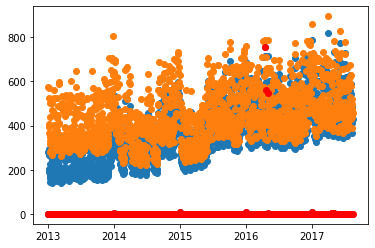

In [18]:
# The overall trend becomes a bit less when the closed stores are removed.

temp = train[['date','sales']].groupby('date').mean()
plt.scatter(temp.index,temp['sales'])
temp = train.loc[train['to_keep'],['date','sales']].groupby('date').mean()
plt.scatter(temp.index,temp['sales'])
temp = train.loc[~train['to_keep'],['date','sales']].groupby('date').mean()
plt.scatter(temp.index,temp['sales'],color = 'red');

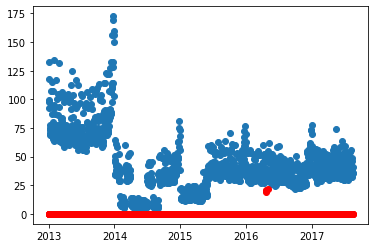

In [19]:
temp = train.loc[train['to_keep'],['date','sales']].groupby('date').median()
plt.scatter(temp.index,temp['sales'])
temp = train.loc[~train['to_keep'],['date','sales']].groupby('date').median()
plt.scatter(temp.index,temp['sales'],color = 'red');

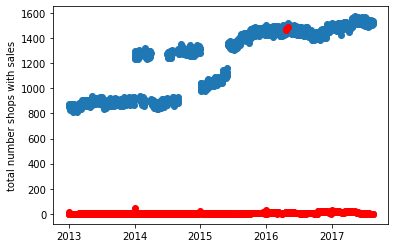

In [20]:
def nb_sales(data):
    return (data > 0).sum()

temp = train.loc[train['to_keep'],['date','sales']].groupby('date').agg(lambda x: nb_sales(x))
plt.scatter(temp.index,temp['sales'])
temp = train.loc[~train['to_keep'],['date','sales']].groupby('date').agg(lambda x: nb_sales(x))
plt.scatter(temp.index,temp['sales'],color = 'red')
plt.ylabel('total number shops with sales');

In [21]:
# Cut out everything before the 1st of january 2016.
# Assume that any shop that did'nt make sales after june 2015 is closed.
opening_dates.loc[(opening_dates['last_date'] < datetime(2015,6,1)),'closed_store'] = True
for (store_nb, fam) in opening_dates.loc[(opening_dates['last_date'] < datetime(2015,6,1)),'closed_store'].index:
    train.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam), 'closed_store'] = True
train.loc[train['date'] < datetime(2016,1,1),'to_keep'] = False

In [22]:
# Check that all the stores with nothing 'to_keep' are labeld as closed.
opening_dates[(opening_dates['last_date'] < datetime(2016,1,1))]

,,first_date,last_date,sales_count,sales_density,closed_store
store_nbr,family,,,,,
10,LAWN AND GARDEN,2014-10-29,2015-11-07,14,0.037333,True
12,LAWN AND GARDEN,2014-05-09,2014-10-31,5,0.028409,True
13,LAWN AND GARDEN,2014-05-10,2015-05-10,9,0.024590,True
15,LAWN AND GARDEN,2014-05-10,2015-05-10,3,0.008197,True
16,LAWN AND GARDEN,2014-10-29,2015-11-05,11,0.029491,True
17,LAWN AND GARDEN,2014-05-08,2015-11-03,40,0.073394,True
19,LAWN AND GARDEN,2014-10-30,2015-11-01,4,0.010870,True
22,LAWN AND GARDEN,2015-10-27,2015-12-26,6,0.098361,True
32,LAWN AND GARDEN,2015-12-16,2015-12-20,5,1.000000,True


In [24]:
#Check that there are no shops with sales only in the test data.
train_cut = 0.94
print('Start of test data:',train['date'].min()+train_cut*(train['date'].max()-train['date'].min()))
print('Last date:',train['date'].max())
opening_dates[opening_dates['first_date'] > train['date'].min()+train_cut*(train['date'].max()-train['date'].min())]

Start of test data: 2017-05-05 18:43:12
Last date: 2017-08-15 00:00:00


,,first_date,last_date,sales_count,sales_density,closed_store
store_nbr,family,,,,,
6,BABY CARE,2017-07-10,2017-07-24,7,0.466667,True


In [25]:
train['train_set'] = True
train.loc[train['date'] > train['date'].min()+train_cut*(train['date'].max()-train['date'].min()),'train_set'] = False

target = train[['date', 'store_nbr', 'family', 'to_keep', 'sales', 'train_set','closed_store']].copy()
train = train.drop('sales', axis = 1)
target['log_sales'] = np.log(1+target['sales'].astype(float))
target[['sales','log_sales']] = target[['sales','log_sales']].astype(float)

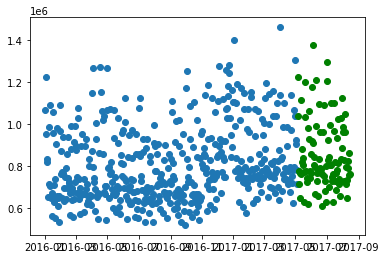

In [26]:
temp = target.loc[target['to_keep'] & target['train_set'],['date','sales']].groupby('date').sum()
plt.scatter(temp.index,temp['sales'])

temp = target.loc[target['to_keep'] & ~target['train_set'],['date','sales']].groupby('date').sum()
plt.scatter(temp.index,temp['sales'],color = 'green');

In [30]:
%store train target

Stored 'train' (DataFrame)
Stored 'target' (DataFrame)


# Features

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

def RMSLE(y_prediction,y_measured):
    return np.sqrt(np.mean((np.log((1+y_prediction)/(1+y_measured))**2)))

%store -r train target

In [39]:
train.head()

,date,store_nbr,family,onpromotion,to_keep,closed_store,train_set,is_weekend,weekday
0.0,2013-01-01,1,AUTOMOTIVE,0,False,False,True,False,1
890.0,2013-01-01,33,SEAFOOD,0,False,False,True,False,1
2.0,2013-01-01,1,BEAUTY,0,False,False,True,False,1
3.0,2013-01-01,1,BEVERAGES,0,False,False,True,False,1
4.0,2013-01-01,1,BOOKS,0,False,False,True,False,1


In [40]:
target.head()

,date,store_nbr,family,to_keep,sales,train_set,closed_store,log_sales,mean,mean_log,prediction
0.0,2013-01-01,1,AUTOMOTIVE,False,0.0,True,False,0.0,NaN,NaN,NaN
890.0,2013-01-01,33,SEAFOOD,False,0.0,True,False,0.0,NaN,NaN,NaN
2.0,2013-01-01,1,BEAUTY,False,0.0,True,False,0.0,NaN,NaN,NaN
3.0,2013-01-01,1,BEVERAGES,False,0.0,True,False,0.0,NaN,NaN,NaN
4.0,2013-01-01,1,BOOKS,False,0.0,True,False,0.0,NaN,NaN,NaN


In [41]:
train['is_weekend'] = train['date'].dt.weekday > 4
#one-hot-encode weekday
train['weekday'] = train['date'].dt.weekday
train = pd.concat([train,pd.get_dummies(train['weekday']).drop([0], axis = 1)], axis = 1)

In [42]:
# 1 day and 1 week shift
time = datetime(2023,1,1).utcnow()
cut_date = datetime(2016,1,1)
temp = target.loc[target['date'] >= cut_date, ['date','store_nbr','family','sales','log_sales']].copy()
temp['onpromotion'] = train.loc[target['date'] >= cut_date, 'onpromotion']
temp_train = train.loc[target['date'] >= cut_date, ['store_nbr','family']].copy()
for (store_nb,fam) in train[['store_nbr','family']].groupby(['store_nbr','family']).mean().index:
    temp2 = temp.loc[(temp_train['store_nbr'] == store_nb) & (temp_train['family'] == fam),['sales','date','log_sales','onpromotion']].sort_values('date').set_index('date').asfreq('d')
    temp2['sales_shift_1d'] = temp2['sales'].shift(1)
    temp2['sales_shift_7d'] = temp2['sales'].shift(7)
    temp2['log_sales_shift_1d'] = temp2['log_sales'].shift(1)
    temp2['log_sales_shift_7d'] = temp2['log_sales'].shift(7)
    temp2['onpromotion_shift_1d'] = temp2['onpromotion'].shift(1)
    temp2['onpromotion_shift_7d'] = temp2['onpromotion'].shift(7)
    temp_train.loc[(temp_train['store_nbr'] == store_nb) & (temp_train['family'] == fam),['sales_shift_1d','sales_shift_7d','log_sales_shift_1d','log_sales_shift_7d','onpromotion_shift_1d','onpromotion_shift_7d']] = temp2[['sales_shift_1d','sales_shift_7d','log_sales_shift_1d','log_sales_shift_7d','onpromotion_shift_1d','onpromotion_shift_7d']].values
train.loc[target['date'] >= cut_date,['sales_shift_1d','sales_shift_7d','log_sales_shift_1d','log_sales_shift_7d','onpromotion_shift_1d','onpromotion_shift_7d']] = temp_train[['sales_shift_1d','sales_shift_7d','log_sales_shift_1d','log_sales_shift_7d','onpromotion_shift_1d','onpromotion_shift_7d']].values
print(datetime(2023,1,1).utcnow()-time)

0:06:13.854739


# Models

## Individual means

In [43]:
individual_means = target.loc[target['to_keep'] & target['train_set'] & ~target['closed_store'], ['store_nbr','family','sales','log_sales']].groupby(['store_nbr','family']).mean()
individual_means.head()

sales  log_sales
store_nbr family                              
1         AUTOMOTIVE       4.243299   1.491005
          BEAUTY           2.909278   1.201914
          BEVERAGES     2081.872165   7.590513
          BOOKS            0.886700   0.480790
          BREAD/BAKERY   386.316979   5.896795

In [7]:
time = datetime(2023,1,1).utcnow()
temp = target.loc[target['to_keep'] & (~target['train_set']) & (~target['closed_store']),['store_nbr','family']].copy()
for (store_nb,fam) in individual_means.index:
    temp.loc[(temp['store_nbr'] == store_nb) & (temp['family'] == fam),['mean','mean_log']] = individual_means.loc[(store_nb,fam),['sales','log_sales']].values
temp['mean'] = temp['mean'].fillna(0)
temp['mean_log'] = temp['mean_log'].fillna(0)
target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),['mean','mean_log']] = temp[['mean','mean_log']].values
print(datetime(2023,1,1).utcnow()-time)

0:00:30.236784


In [8]:
print('Score mean:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'sales'],target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'mean']))
print('Score mean log:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'mean_log'])-1))

scores = pd.DataFrame([],columns = ['mean','mean_log','score'])
scores.loc[0,['mean','mean_log','score']] = [True, False, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'sales'],target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'mean'])]
scores.loc[1,['mean','mean_log','score']] = [False, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'mean_log'])-1)]

Score mean: 0.5348300323162434
Score mean log: 0.5528606333818018


## Linear regressions

In [9]:
features = [1,2,3,4,5,6]
target_name = 'sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set']  & (~target['closed_store']),'sales'],linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~target['closed_store']),features].values)))

scores.loc[2,['mean','mean_log','lin_reg','score']] = [False, False, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~target['closed_store']),'sales'],linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~target['closed_store']),features].values))]

Linreg score:  0.0036384024366502565
Slope:  [-27.6968895   -6.10968107 -85.36903977 -13.13383102 120.3319591
 165.88514046]
Constant:  475.6371352378489

Score: 3.361078939956314


In [10]:
features = [1,2,3,4,5,6]
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[3,['mean','mean_log','lin_reg','log_target','score']] = [False, False, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Linreg score:  0.002808262316481125
Slope:  [-0.03244182 -0.02988145 -0.08634079  0.04129697  0.2891093   0.22048343]
Constant:  3.729513559914127

Score: 2.422729275421135


In [76]:
time = datetime(2023,1,1).utcnow()
features = [1,2,3,4,5,6, 'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'log_sales'

for (store_nb,fam) in individual_means.index:
    X = train.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
    y = target.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
    linreg = LinearRegression().fit(X,y)
    target.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & (~train['closed_store']) & (~train['train_set']),'prediction'] = linreg.predict(train.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & (~train['closed_store']) & ~train['train_set'],features].values)
print(datetime(2023,1,1).utcnow()-time)

1:23:41.148245


In [78]:
scores.loc[11,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','onpromotion_shifts', 'shop-wise models', 'score']] = [False, False, True, False, True, True, True, True, RMSLE(target.loc[~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[~target['train_set'] & (~train['closed_store']),'prediction'])-1)]

RMSLE(target.loc[~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[~target['train_set'] & (~train['closed_store']),'prediction'])-1)

0.49705013366439255

In [33]:
# To avoid re-calculating it
scores.loc[11,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','onpromotion_shifts', 'shop-wise models', 'score']] = [False, False, True, False, True, True, True, True, 0.49705013366439255]

print(0.49705013366439255)

0.49705013366439255


In [34]:
time = datetime(2023,1,1).utcnow()
features = [1,2,3,4,5,6, 'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'sales'

for (store_nb,fam) in individual_means.index:
    X = train.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
    y = target.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
    linreg = LinearRegression().fit(X,y)
    target.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & (~train['closed_store']) & (~train['train_set']),'prediction'] = linreg.predict(train.loc[(train['store_nbr'] == store_nb) & (train['family'] == fam) & (~train['closed_store']) & ~train['train_set'],features].values)
print(datetime(2023,1,1).utcnow()-time)

1:09:34.664956


In [54]:
scores.loc[12,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','onpromotion_shifts', 'shop-wise models', 'score']] = [False, False, True, False, False, True, True, True, RMSLE(target.loc[~target['train_set'] & (~train['closed_store']),'sales'],target.loc[~target['train_set'] & (~train['closed_store']),'prediction'])]

RMSLE(target.loc[~target['train_set'] & (~train['closed_store']),'sales'],target.loc[~target['train_set'] & (~train['closed_store']),'prediction'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.4766373613393779

In [44]:
time = datetime(2023,1,1).utcnow()
temp = target.loc[target['to_keep'] & (target['train_set']),['store_nbr','family']].copy()
for (store_nb,fam) in individual_means.index:
    temp.loc[(temp['store_nbr'] == store_nb) & (temp['family'] == fam),['mean','mean_log']] = individual_means.loc[(store_nb,fam),['sales','log_sales']].values
temp['mean'] = temp['mean'].fillna(0)
temp['mean_log'] = temp['mean_log'].fillna(0)
target.loc[target['to_keep'] & target['train_set'],['mean','mean_log']] = temp[['mean','mean_log']].values
print(datetime(2023,1,1).utcnow()-time)

0:02:06.117706


In [45]:
features = [1,2,3,4,5,6]
target_name = 'sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values - target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean'].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values)))

scores.loc[4,['mean','mean_log','lin_reg','log_target','score']] = [True, False, True, False, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))]

Linreg score:  0.030978859690867666
Slope:  [-27.75451847  -6.14546914 -85.44524833 -13.23120583 120.24812352
 165.70980495]
Constant:  -21.616160067085396

Score: 1.5715450056325782


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
features = [1,2,3,4,5,6]
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values - target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean_log'].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[5,['mean','mean_log','lin_reg','log_target','score']] = [False, True, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Linreg score:  0.04466715939516164
Slope:  [-0.03287367 -0.0301541  -0.08649189  0.04098133  0.28848837  0.21923209]
Constant:  -0.05687011546916776

Score: 0.5337126788075726


In [47]:
features = [1,2,3,4,5,6,'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values - target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean_log'].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[9,['mean','mean_log','lin_reg','log_target','onpromotion','onpromotion_shifts','score']] = [False, True, True, True, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Linreg score:  0.05270039321492492
Slope:  [-0.03702937 -0.04430859 -0.08071621  0.0307231   0.29026606  0.21738338
  0.00413875 -0.00088112 -0.00086201]
Constant:  -0.06952633553288397

Score: 0.5317181603534838


In [48]:
features = [1,2,3,4,5,6,'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values - target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean'].values
linreg = LinearRegression().fit(X,y)
print('Linreg score: ',linreg.score(X,y))
print('Slope: ',linreg.coef_)
print('Constant: ',linreg.intercept_)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),target_name],target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values)))

scores.loc[10,['mean','mean_log','lin_reg','log_target','onpromotion','onpromotion_shifts','score']] = [True, False, True, False, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),target_name],target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean'].values+linreg.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))]

Linreg score:  0.0699279152710609
Slope:  [-36.66775702 -31.49690856 -71.59259641 -33.66702357 127.08568764
 159.8105231    5.38088814  -2.91510091   0.37837303]
Constant:  -34.78218542772812

Score: 1.556594660171177


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Gradient boost

In [49]:
features = [1,2,3,4,5,6]
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
xgb = XGBRegressor()
xgb.fit(X, y)

print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[6,['mean','mean_log','lin_reg','xgb','log_target','score']] = [False, False, False, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Score: 2.4227292904677444


In [50]:
features = [1,2,3,4,5,6, 'onpromotion']
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
xgb = XGBRegressor()
xgb.fit(X, y)

print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[7,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','score']] = [False, False, False, True, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Score: 1.59519265141103


In [51]:
features = [1,2,3,4,5,6, 'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values
xgb = XGBRegressor()
xgb.fit(X, y)

print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[8,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','onpromotion_shifts', 'score']] = [False, False, False, True, True, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]

Score: 1.4678890945018452


In [52]:
features = [1,2,3,4,5,6,'onpromotion','onpromotion_shift_1d', 'onpromotion_shift_7d']
target_name = 'log_sales'
X = train.loc[train['to_keep'] & train['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),features].values
y = target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),target_name].values - target.loc[target['to_keep'] & target['train_set'] & (~train['closed_store']) & (~train[features].isnull().any(axis = 1)),'mean_log'].values
xgb = XGBRegressor()
xgb.fit(X,y)

print()
print('Score:',RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1))

scores.loc[10,['mean','mean_log','lin_reg','xgb','log_target','onpromotion','onpromotion_shifts', 'score']] = [False, True, False, True, True, True, True, RMSLE(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'sales'],np.exp(target.loc[target['to_keep'] & ~target['train_set'] & (~train['closed_store']),'mean_log'].values+xgb.predict(train.loc[train['to_keep'] & ~train['train_set'] & (~train['closed_store']),features].values))-1)]


Score: 0.5295791852370338


,mean,mean_log,score,lin_reg,log_target,xgb,onpromotion,onpromotion_shifts,shop-wise models
12,False,False,0.476637,True,False,False,True,True,True
11,False,False,0.497050,True,True,False,True,True,True
10,False,True,0.529579,False,True,True,True,True,False
9,False,True,0.531718,True,True,False,True,True,False
5,False,True,0.533713,True,True,False,False,False,False
0,True,False,0.534830,False,False,False,False,False,False
1,False,True,0.552861,False,False,False,False,False,False
8,False,False,1.467889,False,True,True,True,True,False
4,True,False,1.571545,True,False,False,False,False,False
7,False,False,1.595193,False,True,True,True,False,False


(0.4, 0.6)

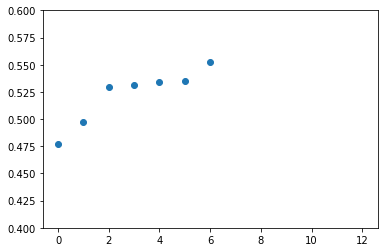

In [55]:
scores = scores.fillna(False)
scores = scores.sort_values('score')
display(scores)
plt.scatter(np.arange(len(scores)),scores['score'])
plt.ylim([0.4,0.6])

# Leaderboard

In [56]:
leaderboard = pd.read_csv('store-sales-time-series-forecasting-publicleaderboard-2023-10-16T17:18:17.csv',index_col = 'Rank')
leaderboard.head()

,TeamId,TeamName,LastSubmissionDate,Score,SubmissionCount,TeamMemberUserNames
Rank,,,,,,
1,10601957,Jason_,2023-10-16 05:05:48,0.37786,1,jaso1024
2,7906094,Javier Reinoso Velasco,2023-10-07 21:24:33,0.37793,2,javierreinoso
3,10936873,CCHK(a.k.a new_ITZY),2023-10-04 13:43:34,0.37887,40,"chense,harrischoe,ikjeee,stevekskim"
4,10991187,ikzyyy,2023-10-03 13:49:54,0.37889,18,ikzyyy
5,10907407,JueYeong,2023-09-27 07:26:30,0.37929,1,jueyeong


In [57]:
my_score = scores['score'].min()
print('Ranking:',(leaderboard['Score'] < my_score).sum(),'of',len(leaderboard))
print('Relative ranking:',(leaderboard['Score'] < my_score).sum()/len(leaderboard))
print()
print('Percentiles:')
leaderboard['Score'].describe()[['25%','50%','75%']]

Ranking: 146 of 635
Relative ranking: 0.22992125984251968

Percentiles:


25%    0.494715
50%    0.510900
75%    1.053110
Name: Score, dtype: float64

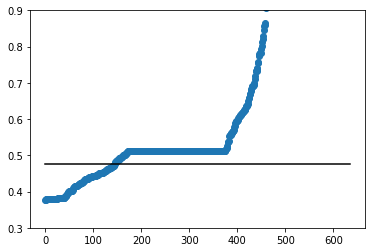

In [58]:
plt.scatter(np.arange(len(leaderboard)),leaderboard['Score'])
plt.plot(np.arange(len(leaderboard)),[my_score]*len(leaderboard),color = 'k')
plt.ylim([0.3,0.9]);
#plt.yscale('log')

# Winning model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

def RMSLE(y_prediction,y_measured):
    return np.sqrt(np.mean((np.log((1+y_prediction)/(1+y_measured))**2)))

%store -r train target

In [2]:
test = pd.read_csv('test.csv',index_col = 'id')
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values('date')
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3002082,2017-08-16,42,CELEBRATION,0
3002081,2017-08-16,42,BREAD/BAKERY,12
3002080,2017-08-16,42,BOOKS,0
3002079,2017-08-16,42,BEVERAGES,19


In [6]:
# 1 day and 1 week shift
time = datetime(2023,1,1).utcnow()

test['test'] = True
test['to_keep'] = True
test['closed_store'] = False
closed_stores = train[train['closed_store']].groupby(['store_nbr','family']).count().index
for (store_nb, fam) in closed_stores:
    test.loc[(test['store_nbr'] == store_nb) & (test['family'] == fam),'closed_store'] = True
train['test'] = False
train['sales'] = target['sales']
data = pd.concat([test,train]).sort_values('date')
#one-hot-encode weekday
data['weekday'] = data['date'].dt.weekday
data = pd.concat([data,pd.get_dummies(data['weekday']).drop([0], axis = 1)], axis = 1)
data = data.drop('weekday', axis = 1)
data['onpromotion'] = data['onpromotion'].astype(int)

cut_date = datetime(2016,1,1)
temp = data.loc[(~data['closed_store']) & (data['date'] >= cut_date), ['date','store_nbr','family','onpromotion']].sort_values('date').copy()
for (store_nb,fam) in temp[['store_nbr','family']].groupby(['store_nbr','family']).mean().index:
    temp2 = temp.loc[(temp['store_nbr'] == store_nb) & (temp['family'] == fam),['date','onpromotion']].copy().sort_values('date').set_index('date').asfreq('d')
    temp2['onpromotion_shift_1d'] = temp2['onpromotion'].shift(1)
    temp2['onpromotion_shift_2d'] = temp2['onpromotion'].shift(2)
    temp2['onpromotion_shift_3d'] = temp2['onpromotion'].shift(3)
    temp2['onpromotion_shift_4d'] = temp2['onpromotion'].shift(4)
    temp2['onpromotion_shift_5d'] = temp2['onpromotion'].shift(5)
    temp2['onpromotion_shift_6d'] = temp2['onpromotion'].shift(6)
    temp2['onpromotion_shift_7d'] = temp2['onpromotion'].shift(7)
    temp.loc[(temp['store_nbr'] == store_nb) & (temp['family'] == fam),['onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d']] = temp2[['onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d']].values
data.loc[(~data['closed_store']) & (data['date'] >= cut_date),['onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d']] = temp[['onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d']]
print(datetime(2023,1,1).utcnow()-time)

0:05:17.371570


In [7]:
# Insert the zero predictions for the closed stores
for (store_nb, fam) in closed_stores:
    data.loc[data['test'] & (data['store_nbr'] == store_nb) & (data['family'] == fam),'prediction'] = 0

In [8]:
time = datetime(2023,1,1).utcnow()
features = [1,2,3,4,5,6, 'onpromotion','onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d']
open_stores = train[~train['closed_store']].groupby(['store_nbr','family']).count().index
temp = data.loc[data['date'] > cut_date,['store_nbr', 'family', 'onpromotion', 'test', 'to_keep', 1, 2, 3, 4, 5, 6, 'onpromotion_shift_1d','onpromotion_shift_2d','onpromotion_shift_3d','onpromotion_shift_4d','onpromotion_shift_5d','onpromotion_shift_6d','onpromotion_shift_7d', 'sales']].copy()
for (store_nb,fam) in open_stores:
    temp2 = temp[(temp['store_nbr'] == store_nb) & (temp['family'] == fam) & (~temp['test']) & temp['to_keep']].copy().dropna()
    X = temp2[features].values
    y = temp2['sales'].values
    linreg = LinearRegression().fit(X,y)
    data.loc[(data['store_nbr'] == store_nb) & (data['family'] == fam) & data['test'],'prediction'] = linreg.predict(data.loc[(data['store_nbr'] == store_nb) & (data['family'] == fam) & data['test'],features].values)
print(datetime(2023,1,1).utcnow()-time)

0:17:36.497548


In [9]:
temp = data.loc[data['test'],['prediction']].rename(columns = {'prediction':'sales'})
temp.index.name = 'id'
temp.to_csv('predictions_2.csv')